In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "high_z"
key = "lambda"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

10it [00:00, 94.93it/s]

22it [00:00, 99.73it/s]

34it [00:00, 104.28it/s]

45it [00:00, 104.49it/s]

57it [00:00, 108.63it/s]

69it [00:00, 109.78it/s]

81it [00:00, 112.10it/s]

93it [00:00, 114.05it/s]

105it [00:00, 115.17it/s]

117it [00:01, 115.30it/s]

129it [00:01, 115.30it/s]

141it [00:01, 110.14it/s]

153it [00:01, 110.97it/s]

165it [00:01, 111.50it/s]

177it [00:01, 112.64it/s]

189it [00:01, 113.37it/s]

201it [00:01, 114.54it/s]

214it [00:01, 116.20it/s]

227it [00:01, 117.32it/s]

239it [00:02, 117.88it/s]

251it [00:02, 117.81it/s]

263it [00:02, 117.86it/s]

275it [00:02, 117.54it/s]

287it [00:02, 95.59it/s] 

298it [00:02, 98.57it/s]

310it [00:02, 103.67it/s]

322it [00:02, 107.34it/s]

334it [00:03, 107.32it/s]

346it [00:03, 110.51it/s]

359it [00:03, 113.22it/s]

371it [00:03, 113.95it/s]

383it [00:03, 97.29it/s] 

394it [00:03, 98.01it/s]

406it [00:03, 102.54it/s]

418it [00:03, 106.77it/s]

430it [00:03, 109.56it/s]

442it [00:04, 111.87it/s]

454it [00:04, 113.72it/s]

467it [00:04, 115.81it/s]

479it [00:04, 112.01it/s]

491it [00:04, 112.49it/s]

503it [00:04, 103.02it/s]

515it [00:04, 106.54it/s]

527it [00:04, 109.14it/s]

539it [00:04, 111.67it/s]

551it [00:04, 113.98it/s]

563it [00:05, 111.66it/s]

575it [00:05, 109.72it/s]

587it [00:05, 111.98it/s]

599it [00:05, 112.73it/s]

611it [00:05, 110.73it/s]

623it [00:05, 112.15it/s]

635it [00:05, 113.81it/s]

647it [00:05, 115.53it/s]

659it [00:05, 114.82it/s]

671it [00:06, 111.33it/s]

683it [00:06, 113.37it/s]

695it [00:06, 114.94it/s]

707it [00:06, 115.49it/s]

719it [00:06, 115.23it/s]

731it [00:06, 112.04it/s]

743it [00:06, 113.42it/s]

755it [00:06, 114.59it/s]

767it [00:06, 113.02it/s]

779it [00:06, 114.17it/s]

791it [00:07, 114.75it/s]

803it [00:07, 116.13it/s]

815it [00:07, 116.67it/s]

827it [00:07, 116.94it/s]

839it [00:07, 116.93it/s]

851it [00:07, 117.28it/s]

863it [00:07, 118.03it/s]

876it [00:07, 118.27it/s]

888it [00:07, 118.57it/s]

900it [00:08, 117.63it/s]

912it [00:08, 117.64it/s]

924it [00:08, 112.55it/s]

937it [00:08, 115.13it/s]

949it [00:08, 100.48it/s]

960it [00:08, 101.23it/s]

971it [00:08, 103.19it/s]

983it [00:08, 106.56it/s]

995it [00:08, 109.08it/s]

1007it [00:09, 111.18it/s]

1019it [00:09, 112.76it/s]

1031it [00:09, 113.01it/s]

1043it [00:09, 112.53it/s]

1055it [00:09, 112.82it/s]

1067it [00:09, 112.70it/s]

1079it [00:09, 109.45it/s]

1091it [00:09, 111.11it/s]

1103it [00:09, 106.83it/s]

1114it [00:09, 106.93it/s]

1125it [00:10, 102.66it/s]

1137it [00:10, 106.86it/s]

1149it [00:10, 109.42it/s]

1161it [00:10, 111.16it/s]

1173it [00:10, 112.80it/s]

1185it [00:10, 112.78it/s]

1197it [00:10, 114.14it/s]

1209it [00:10, 114.28it/s]

1221it [00:10, 111.58it/s]

1233it [00:11, 107.37it/s]

1245it [00:11, 109.15it/s]

1257it [00:11, 111.22it/s]

1269it [00:11, 113.56it/s]

1282it [00:11, 116.64it/s]

1295it [00:11, 118.81it/s]

1307it [00:11, 108.04it/s]

1319it [00:11, 109.76it/s]

1331it [00:11, 112.11it/s]

1343it [00:12, 110.29it/s]

1356it [00:12, 113.28it/s]

1368it [00:12, 113.80it/s]

1380it [00:12, 114.47it/s]

1392it [00:12, 115.05it/s]

1404it [00:12, 110.30it/s]

1416it [00:12, 107.95it/s]

1427it [00:12, 107.17it/s]

1439it [00:12, 108.44it/s]

1450it [00:13, 97.15it/s] 

1461it [00:13, 98.63it/s]

1473it [00:13, 103.64it/s]

1485it [00:13, 107.22it/s]

1496it [00:13, 96.55it/s] 

1506it [00:13, 88.82it/s]

1516it [00:13, 85.23it/s]

1525it [00:13, 81.86it/s]

1536it [00:13, 88.03it/s]

1548it [00:14, 95.15it/s]

1558it [00:14, 94.71it/s]

1568it [00:14, 87.33it/s]

1578it [00:14, 87.38it/s]

1589it [00:14, 92.65it/s]

1601it [00:14, 97.42it/s]

1613it [00:14, 101.41it/s]

1626it [00:14, 106.40it/s]

1638it [00:14, 107.90it/s]

1650it [00:15, 107.41it/s]

1662it [00:15, 109.60it/s]

1674it [00:15, 94.70it/s] 

1685it [00:15, 98.26it/s]

1697it [00:15, 101.81it/s]

1709it [00:15, 105.52it/s]

1721it [00:15, 107.98it/s]

1732it [00:15, 108.10it/s]

1743it [00:15, 107.00it/s]

1754it [00:16, 107.82it/s]

1765it [00:16, 100.94it/s]

1776it [00:16, 90.21it/s] 

1786it [00:16, 83.43it/s]

1798it [00:16, 91.05it/s]

1810it [00:16, 97.56it/s]

1822it [00:16, 101.89it/s]

1833it [00:16, 95.99it/s] 

1843it [00:17, 88.25it/s]

1853it [00:17, 85.33it/s]

1864it [00:17, 89.71it/s]

1875it [00:17, 93.49it/s]

1885it [00:17, 90.77it/s]

1897it [00:17, 97.19it/s]

1907it [00:17, 97.21it/s]

1919it [00:17, 101.92it/s]

1931it [00:17, 105.57it/s]

1943it [00:18, 108.40it/s]

1954it [00:18, 103.71it/s]

1966it [00:18, 107.47it/s]

1978it [00:18, 110.80it/s]

1990it [00:18, 112.71it/s]

2002it [00:18, 114.08it/s]

2014it [00:18, 115.61it/s]

2026it [00:18, 91.36it/s] 

2036it [00:19, 86.29it/s]

2046it [00:19, 89.53it/s]

2056it [00:19, 91.18it/s]

2068it [00:19, 97.37it/s]

2079it [00:19, 100.43it/s]

2091it [00:19, 104.76it/s]

2103it [00:19, 108.29it/s]

2115it [00:19, 110.20it/s]

2127it [00:19, 111.23it/s]

2139it [00:19, 108.04it/s]

2150it [00:20, 103.71it/s]

2161it [00:20, 105.46it/s]

2172it [00:20, 99.54it/s] 

2184it [00:20, 101.47it/s]

2195it [00:20, 91.99it/s] 

2206it [00:20, 96.22it/s]

2217it [00:20, 98.51it/s]

2228it [00:20, 100.37it/s]

2239it [00:20, 102.08it/s]

2250it [00:21, 102.65it/s]

2261it [00:21, 99.76it/s] 

2273it [00:21, 103.81it/s]

2286it [00:21, 108.44it/s]

2298it [00:21, 111.49it/s]

2310it [00:21, 112.68it/s]

2322it [00:21, 113.39it/s]

2334it [00:21, 113.48it/s]

2346it [00:21, 113.05it/s]

2358it [00:22, 114.36it/s]

2371it [00:22, 116.82it/s]

2383it [00:22, 117.08it/s]

2395it [00:22, 117.58it/s]

2407it [00:22, 118.26it/s]

2419it [00:22, 118.09it/s]

2431it [00:22, 117.74it/s]

2443it [00:22, 101.35it/s]

2454it [00:22, 90.09it/s] 

2464it [00:23, 85.05it/s]

2473it [00:23, 83.53it/s]

2485it [00:23, 91.09it/s]

2495it [00:23, 90.03it/s]

2505it [00:23, 87.79it/s]

2518it [00:23, 95.85it/s]

2530it [00:23, 100.27it/s]

2542it [00:23, 104.83it/s]

2554it [00:23, 107.40it/s]

2565it [00:24, 97.01it/s] 

2577it [00:24, 102.03it/s]

2589it [00:24, 105.96it/s]

2601it [00:24, 109.07it/s]

2613it [00:24, 109.60it/s]

2625it [00:24, 103.62it/s]

2637it [00:24, 107.56it/s]

2649it [00:24, 110.15it/s]

2661it [00:24, 112.02it/s]

2673it [00:25, 112.34it/s]

2685it [00:25, 109.04it/s]

2696it [00:25, 100.43it/s]

2708it [00:25, 105.38it/s]

2720it [00:25, 108.93it/s]

2732it [00:25, 111.83it/s]

2744it [00:25, 110.40it/s]

2756it [00:25, 107.04it/s]

2767it [00:25, 105.13it/s]

2779it [00:26, 107.91it/s]

2791it [00:26, 110.62it/s]

2803it [00:26, 112.64it/s]

2815it [00:26, 114.25it/s]

2827it [00:26, 115.68it/s]

2839it [00:26, 116.32it/s]

2852it [00:26, 117.34it/s]

2864it [00:26, 117.83it/s]

2876it [00:26, 118.34it/s]

2888it [00:26, 118.59it/s]

2900it [00:27, 118.42it/s]

2912it [00:27, 117.95it/s]

2924it [00:27, 116.96it/s]

2936it [00:27, 116.67it/s]

2948it [00:27, 115.84it/s]

2960it [00:27, 112.22it/s]

2972it [00:27, 113.73it/s]

2984it [00:27, 115.08it/s]

2996it [00:27, 115.34it/s]

3008it [00:28, 116.58it/s]

3020it [00:28, 116.78it/s]

3032it [00:28, 116.81it/s]

3044it [00:28, 116.36it/s]

3056it [00:28, 116.00it/s]

3068it [00:28, 116.76it/s]

3080it [00:28, 116.61it/s]

3092it [00:28, 116.88it/s]

3104it [00:28, 101.63it/s]

3115it [00:29, 99.72it/s] 

3127it [00:29, 104.63it/s]

3139it [00:29, 107.43it/s]

3151it [00:29, 110.37it/s]

3163it [00:29, 111.96it/s]

3175it [00:29, 113.29it/s]

3187it [00:29, 113.10it/s]

3199it [00:29, 114.13it/s]

3211it [00:29, 107.62it/s]

3222it [00:30, 93.93it/s] 

3234it [00:30, 98.75it/s]

3246it [00:30, 103.42it/s]

3257it [00:30, 103.47it/s]

3269it [00:30, 107.06it/s]

3281it [00:30, 108.72it/s]

3293it [00:30, 102.64it/s]

3304it [00:30, 101.91it/s]

3316it [00:30, 106.49it/s]

3328it [00:30, 110.02it/s]

3341it [00:31, 112.89it/s]

3353it [00:31, 114.39it/s]

3365it [00:31, 114.28it/s]

3377it [00:31, 115.06it/s]

3389it [00:31, 116.21it/s]

3401it [00:31, 117.05it/s]

3414it [00:31, 118.34it/s]

3426it [00:31, 118.26it/s]

3438it [00:31, 117.78it/s]

3450it [00:32, 118.02it/s]

3462it [00:32, 117.29it/s]

3474it [00:32, 117.22it/s]

3486it [00:32, 113.78it/s]

3498it [00:32, 113.82it/s]

3510it [00:32, 110.79it/s]

3522it [00:32, 106.09it/s]

3533it [00:32, 98.16it/s] 

3545it [00:32, 103.08it/s]

3557it [00:33, 106.62it/s]

3568it [00:33, 106.68it/s]

3581it [00:33, 110.30it/s]

3593it [00:33, 112.89it/s]

3605it [00:33, 113.57it/s]

3617it [00:33, 113.80it/s]

3629it [00:33, 109.41it/s]

3641it [00:33, 111.39it/s]

3653it [00:33, 112.06it/s]

3665it [00:33, 113.00it/s]

3677it [00:34, 114.70it/s]

3689it [00:34, 113.65it/s]

3701it [00:34, 114.46it/s]

3713it [00:34, 115.42it/s]

3725it [00:34, 109.26it/s]

3737it [00:34, 107.56it/s]

3749it [00:34, 109.09it/s]

3761it [00:34, 111.46it/s]

3773it [00:34, 113.22it/s]

3785it [00:35, 114.62it/s]

3797it [00:35, 114.64it/s]

3809it [00:35, 114.57it/s]

3821it [00:35, 102.64it/s]

3832it [00:35, 97.64it/s] 

3842it [00:35, 87.05it/s]

3852it [00:35, 84.72it/s]

3863it [00:35, 89.96it/s]

3873it [00:36, 89.19it/s]

3883it [00:36, 91.52it/s]

3893it [00:36, 86.00it/s]

3903it [00:36, 88.93it/s]

3915it [00:36, 95.45it/s]

3927it [00:36, 100.86it/s]

3939it [00:36, 103.42it/s]

3950it [00:36, 92.80it/s] 

3960it [00:36, 86.41it/s]

3969it [00:37, 82.09it/s]

3972it [00:37, 107.05it/s]


0it [00:00, ?it/s]

8it [00:00, 75.32it/s]

Number of empty sat catalogs is 1


17it [00:00, 77.13it/s]

29it [00:00, 85.02it/s]

42it [00:00, 93.56it/s]

54it [00:00, 99.77it/s]

67it [00:00, 105.66it/s]

80it [00:00, 110.65it/s]

93it [00:00, 114.48it/s]

106it [00:00, 117.34it/s]

119it [00:01, 120.17it/s]

132it [00:01, 122.35it/s]

145it [00:01, 122.04it/s]

158it [00:01, 122.90it/s]

171it [00:01, 122.83it/s]

184it [00:01, 123.33it/s]

197it [00:01, 123.84it/s]

210it [00:01, 124.23it/s]

223it [00:01, 124.94it/s]

236it [00:01, 124.54it/s]

249it [00:02, 123.41it/s]

262it [00:02, 122.97it/s]

275it [00:02, 122.33it/s]

288it [00:02, 120.19it/s]

301it [00:02, 116.29it/s]

314it [00:02, 119.50it/s]

327it [00:02, 121.02it/s]

340it [00:02, 106.82it/s]

353it [00:03, 111.27it/s]

366it [00:03, 115.53it/s]

379it [00:03, 117.19it/s]

391it [00:03, 110.64it/s]

404it [00:03, 114.44it/s]

417it [00:03, 116.90it/s]

430it [00:03, 118.38it/s]

443it [00:03, 119.18it/s]

455it [00:03, 119.38it/s]

468it [00:03, 119.62it/s]

480it [00:04, 117.95it/s]

492it [00:04, 115.17it/s]

505it [00:04, 117.26it/s]

518it [00:04, 118.15it/s]

531it [00:04, 120.01it/s]

544it [00:04, 121.38it/s]

557it [00:04, 121.03it/s]

570it [00:04, 121.50it/s]

583it [00:04, 122.72it/s]

596it [00:05, 123.12it/s]

609it [00:05, 109.39it/s]

621it [00:05, 95.68it/s] 

632it [00:05, 91.67it/s]

642it [00:05, 89.62it/s]

654it [00:05, 96.48it/s]

667it [00:05, 103.67it/s]

680it [00:05, 109.86it/s]

693it [00:06, 114.42it/s]

705it [00:06, 115.26it/s]

718it [00:06, 117.44it/s]

731it [00:06, 119.02it/s]

744it [00:06, 118.29it/s]

757it [00:06, 119.65it/s]

770it [00:06, 122.15it/s]

783it [00:06, 117.61it/s]

795it [00:06, 117.41it/s]

807it [00:06, 118.00it/s]

819it [00:07, 117.00it/s]

831it [00:07, 109.27it/s]

844it [00:07, 114.33it/s]

857it [00:07, 116.78it/s]

869it [00:07, 106.38it/s]

880it [00:07, 91.14it/s] 

891it [00:07, 95.21it/s]

901it [00:08, 73.89it/s]

913it [00:08, 82.72it/s]

923it [00:08, 80.05it/s]

934it [00:08, 85.86it/s]

947it [00:08, 94.70it/s]

958it [00:08, 95.67it/s]

969it [00:08, 92.14it/s]

979it [00:08, 89.78it/s]

991it [00:08, 96.58it/s]

1004it [00:09, 103.15it/s]

1016it [00:09, 107.32it/s]

1029it [00:09, 111.30it/s]

1041it [00:09, 113.21it/s]

1054it [00:09, 115.35it/s]

1067it [00:09, 118.08it/s]

1080it [00:09, 120.24it/s]

1093it [00:09, 122.36it/s]

1106it [00:09, 115.64it/s]

1118it [00:09, 116.60it/s]

1130it [00:10, 117.24it/s]

1143it [00:10, 119.39it/s]

1155it [00:10, 119.21it/s]

1168it [00:10, 120.11it/s]

1181it [00:10, 121.24it/s]

1194it [00:10, 121.90it/s]

1207it [00:10, 121.50it/s]

1220it [00:10, 122.03it/s]

1233it [00:10, 121.50it/s]

1246it [00:11, 122.46it/s]

1259it [00:11, 116.04it/s]

1272it [00:11, 119.40it/s]

1285it [00:11, 122.13it/s]

1299it [00:11, 124.24it/s]

1312it [00:11, 125.50it/s]

1326it [00:11, 126.84it/s]

1340it [00:11, 127.96it/s]

1353it [00:11, 128.28it/s]

1367it [00:11, 128.95it/s]

1380it [00:12, 128.55it/s]

1393it [00:12, 128.51it/s]

1406it [00:12, 127.98it/s]

1419it [00:12, 127.83it/s]

1432it [00:12, 127.82it/s]

1445it [00:12, 111.10it/s]

1457it [00:12, 109.03it/s]

1470it [00:12, 112.28it/s]

1483it [00:12, 116.92it/s]

1495it [00:13, 112.11it/s]

1507it [00:13, 113.31it/s]

1520it [00:13, 116.42it/s]

1532it [00:13, 113.47it/s]

1544it [00:13, 102.54it/s]

1555it [00:13, 96.96it/s] 

1565it [00:13, 93.29it/s]

1575it [00:13, 90.60it/s]

1585it [00:14, 88.54it/s]

1597it [00:14, 95.12it/s]

1610it [00:14, 102.20it/s]

1623it [00:14, 108.01it/s]

1636it [00:14, 112.48it/s]

1649it [00:14, 115.76it/s]

1662it [00:14, 118.89it/s]

1675it [00:14, 120.74it/s]

1688it [00:14, 121.12it/s]

1701it [00:14, 122.26it/s]

1714it [00:15, 97.71it/s] 

1727it [00:15, 104.17it/s]

1740it [00:15, 109.36it/s]

1753it [00:15, 114.23it/s]

1766it [00:15, 116.94it/s]

1779it [00:15, 115.82it/s]

1792it [00:15, 118.17it/s]

1805it [00:15, 120.73it/s]

1818it [00:16, 122.53it/s]

1831it [00:16, 123.98it/s]

1844it [00:16, 123.00it/s]

1857it [00:16, 119.79it/s]

1870it [00:16, 119.55it/s]

1882it [00:16, 118.09it/s]

1895it [00:16, 121.05it/s]

1908it [00:16, 123.46it/s]

1921it [00:16, 123.89it/s]

1934it [00:16, 118.17it/s]

1947it [00:17, 119.13it/s]

1960it [00:17, 120.64it/s]

1973it [00:17, 122.12it/s]

1986it [00:17, 122.69it/s]

1999it [00:17, 122.18it/s]

2012it [00:17, 120.87it/s]

2025it [00:17, 122.32it/s]

2038it [00:17, 108.25it/s]

2050it [00:17, 105.45it/s]

2063it [00:18, 110.36it/s]

2076it [00:18, 113.25it/s]

2089it [00:18, 116.01it/s]

2101it [00:18, 111.00it/s]

2114it [00:18, 115.12it/s]

2127it [00:18, 117.09it/s]

2139it [00:18, 103.40it/s]

2151it [00:18, 107.37it/s]

2164it [00:18, 112.48it/s]

2177it [00:19, 115.79it/s]

2190it [00:19, 118.28it/s]

2203it [00:19, 120.23it/s]

2216it [00:19, 121.85it/s]

2229it [00:19, 121.99it/s]

2242it [00:19, 121.41it/s]

2255it [00:19, 120.89it/s]

2268it [00:19, 121.04it/s]

2281it [00:19, 121.01it/s]

2294it [00:20, 121.03it/s]

2307it [00:20, 121.73it/s]

2320it [00:20, 120.00it/s]

2333it [00:20, 120.10it/s]

2346it [00:20, 122.35it/s]

2359it [00:20, 123.49it/s]

2372it [00:20, 124.05it/s]

2385it [00:20, 125.30it/s]

2398it [00:20, 126.02it/s]

2411it [00:20, 126.64it/s]

2424it [00:21, 125.96it/s]

2437it [00:21, 125.05it/s]

2450it [00:21, 108.90it/s]

2462it [00:21, 109.43it/s]

2475it [00:21, 113.62it/s]

2488it [00:21, 117.13it/s]

2501it [00:21, 119.96it/s]

2514it [00:21, 122.35it/s]

2528it [00:21, 124.48it/s]

2541it [00:22, 125.68it/s]

2554it [00:22, 126.11it/s]

2567it [00:22, 121.69it/s]

2580it [00:22, 118.91it/s]

2593it [00:22, 120.92it/s]

2606it [00:22, 122.04it/s]

2619it [00:22, 122.04it/s]

2632it [00:22, 123.79it/s]

2645it [00:22, 124.89it/s]

2658it [00:23, 125.01it/s]

2671it [00:23, 125.92it/s]

2684it [00:23, 126.11it/s]

2697it [00:23, 125.70it/s]

2710it [00:23, 100.28it/s]

2722it [00:23, 104.63it/s]

2735it [00:23, 110.16it/s]

2748it [00:23, 115.32it/s]

2761it [00:23, 119.21it/s]

2774it [00:24, 121.62it/s]

2787it [00:24, 122.98it/s]

2800it [00:24, 123.91it/s]

2813it [00:24, 124.33it/s]

2826it [00:24, 100.12it/s]

2837it [00:24, 95.64it/s] 

2848it [00:24, 91.82it/s]

2858it [00:24, 90.81it/s]

2868it [00:25, 93.25it/s]

2879it [00:25, 97.70it/s]

2892it [00:25, 105.28it/s]

2905it [00:25, 109.14it/s]

2917it [00:25, 99.89it/s] 

2928it [00:25, 93.02it/s]

2940it [00:25, 99.68it/s]

2953it [00:25, 107.03it/s]

2966it [00:25, 112.72it/s]

2979it [00:26, 117.03it/s]

2992it [00:26, 118.81it/s]

3005it [00:26, 116.47it/s]

3017it [00:26, 107.30it/s]

3028it [00:26, 100.98it/s]

3039it [00:26, 99.85it/s] 

3050it [00:26, 96.93it/s]

3063it [00:26, 104.02it/s]

3076it [00:26, 109.55it/s]

3089it [00:27, 114.15it/s]

3101it [00:27, 114.11it/s]

3114it [00:27, 116.79it/s]

3127it [00:27, 119.19it/s]

3140it [00:27, 121.42it/s]

3153it [00:27, 121.61it/s]

3166it [00:27, 112.51it/s]

3179it [00:27, 116.51it/s]

3192it [00:27, 117.49it/s]

3204it [00:28, 117.17it/s]

3217it [00:28, 117.82it/s]

3230it [00:28, 120.43it/s]

3243it [00:28, 121.30it/s]

3256it [00:28, 122.24it/s]

3269it [00:28, 118.45it/s]

3281it [00:28, 118.20it/s]

3295it [00:28, 121.50it/s]

3309it [00:28, 124.33it/s]

3322it [00:28, 125.27it/s]

3335it [00:29, 125.32it/s]

3348it [00:29, 126.43it/s]

3361it [00:29, 124.81it/s]

3374it [00:29, 124.28it/s]

3387it [00:29, 125.55it/s]

3400it [00:29, 119.19it/s]

3413it [00:29, 120.80it/s]

3426it [00:29, 114.00it/s]

3439it [00:29, 117.25it/s]

3452it [00:30, 119.29it/s]

3465it [00:30, 121.37it/s]

3478it [00:30, 121.29it/s]

3491it [00:30, 122.21it/s]

3504it [00:30, 108.60it/s]

3516it [00:30, 105.68it/s]

3529it [00:30, 110.65it/s]

3541it [00:30, 109.01it/s]

3554it [00:30, 113.43it/s]

3567it [00:31, 115.86it/s]

3580it [00:31, 117.73it/s]

3593it [00:31, 119.56it/s]

3606it [00:31, 120.31it/s]

3619it [00:31, 121.59it/s]

3632it [00:31, 119.05it/s]

3644it [00:31, 117.66it/s]

3657it [00:31, 120.87it/s]

3671it [00:31, 123.52it/s]

3684it [00:32, 125.10it/s]

3697it [00:32, 115.07it/s]

3709it [00:32, 115.00it/s]

3722it [00:32, 118.13it/s]

3735it [00:32, 119.13it/s]

3747it [00:32, 103.15it/s]

3758it [00:32, 97.65it/s] 

3769it [00:32, 94.14it/s]

3780it [00:32, 97.84it/s]

3793it [00:33, 104.64it/s]

3806it [00:33, 110.71it/s]

3819it [00:33, 114.79it/s]

3832it [00:33, 117.66it/s]

3844it [00:33, 110.09it/s]

3857it [00:33, 113.67it/s]

3869it [00:33, 96.24it/s] 

3880it [00:33, 90.07it/s]

3892it [00:34, 95.88it/s]

3903it [00:34, 99.39it/s]

3916it [00:34, 106.85it/s]

3929it [00:34, 109.13it/s]

3942it [00:34, 114.11it/s]

3956it [00:34, 118.67it/s]

3969it [00:34, 121.10it/s]

3972it [00:34, 114.48it/s]

Number of empty sat catalogs is 1


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

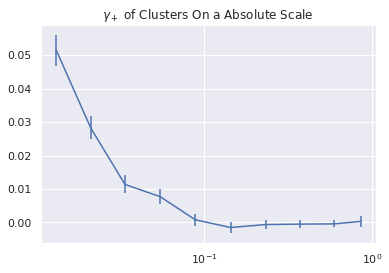

Aggregated xi:
[-30.756  -37.2002 -23.6476 -27.3554  -4.4981  14.2736   8.981    9.8597
   9.4071  -2.5955]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2583.1869  -5066.5809  -7036.3466 -10305.6609 -13791.5325 -18312.9021
 -20770.1452 -19725.6497 -11369.2532  -1241.8144]
------------------------------------------------------------------------------
Aggregated npairs:
[  597.  1314.  2078.  3551.  5695.  9449. 14232. 19993. 21923.  7982.]
------------------------------------------------------------------------------
Mean xi:
[-0.0515 -0.0283 -0.0114 -0.0077 -0.0008  0.0015  0.0006  0.0005  0.0004
 -0.0003]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3269 -3.8558 -3.3861 -2.9022 -2.4217 -1.9381 -1.4594 -0.9866 -0.5186
 -0.1556]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

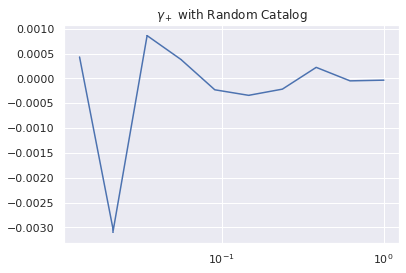

[ 4.3030e-04 -3.0562e-03  8.6036e-04  3.8116e-04 -2.2971e-04 -3.4155e-04
 -2.1683e-04  2.2134e-04 -5.0238e-05 -3.6069e-05]
[-6.8276e-06  4.8493e-05 -1.3651e-05 -6.0478e-06  3.6448e-06  5.4193e-06
  3.4404e-06 -3.5120e-06  7.9712e-07  5.7231e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

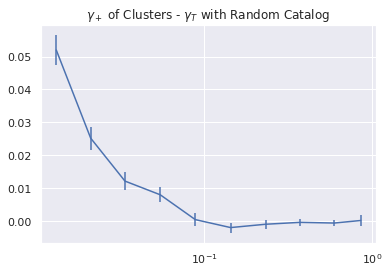

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

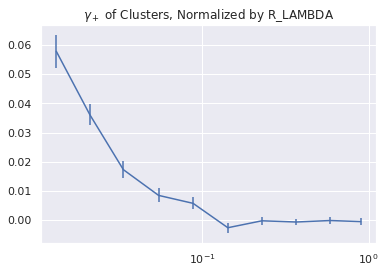

Aggregated xi:
[-22.4037 -36.6058 -30.502  -24.6829 -26.9427  20.9144   3.865   13.1965
   4.9662   9.6795]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1673.2223  -3915.7913  -6006.1763  -8538.9588 -11543.8636 -15107.1111
 -17901.9883 -17893.4896 -11816.4629  -1776.4245]
------------------------------------------------------------------------------
Aggregated npairs:
[  387.  1015.  1769.  2937.  4751.  7752. 12129. 17851. 22197. 16112.]
------------------------------------------------------------------------------
Mean xi:
[-0.0579 -0.0361 -0.0172 -0.0084 -0.0057  0.0027  0.0003  0.0007  0.0002
  0.0006]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3236 -3.8579 -3.3952 -2.9074 -2.4298 -1.9488 -1.476  -1.0024 -0.5323
 -0.1103]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)